In [1]:
%env TIKE_PTYCHO_BACKEND=numpyfft

env: TIKE_PTYCHO_BACKEND=numpyfft


In [2]:
import importlib

import matplotlib.pyplot as plt
import numpy as np

import tike
import tike.ptycho
import tike.view

In [3]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.7.1.dev27+g42563ef.d20191112
numpy is version 1.17.2


# Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

Normalize input uint8 images to the `[0, 1]` and `[0, pi]` ranges.

In [4]:
amplitude = plt.imread("../tests/data/Cryptomeria_japonica-0128.tif") / 255
phase = plt.imread("../tests/data/Bombus_terrestris-0128.tif") / 255 * np.pi
np.min(phase), np.max(phase)

(0.036959913571644624, 3.129272682399245)

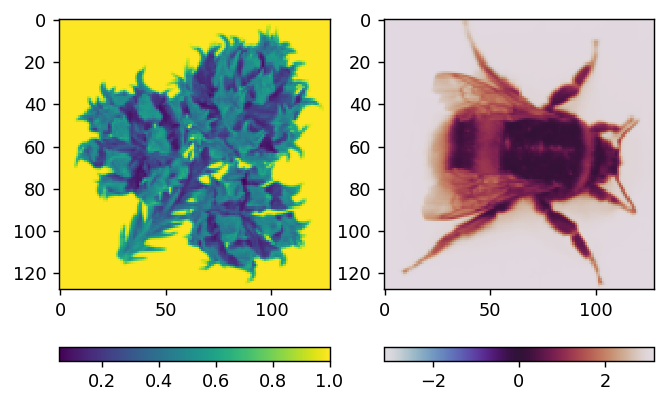

(1, 128, 128)

In [5]:
original = np.expand_dims(amplitude * np.exp(1j * phase), axis=0).astype('complex64')
tike.view.plot_phase(original[0])
original.shape

### Define the probe

(-0.9999241+0.01231966j) (0.99514693+0.09840028j)


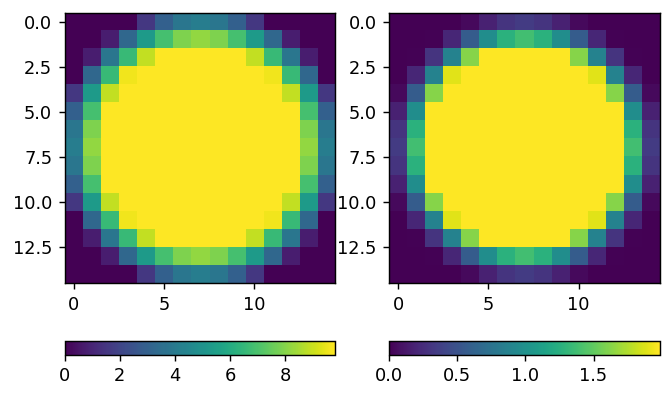

In [6]:
pw = 15 # probe width
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2) * 10
probe = np.expand_dims(probe, axis=0).astype('complex64')
tike.view.plot_complex(probe[0])

### Define the trajectory

In [7]:
v, h = np.meshgrid(
    np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=True),
    np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=True),
    indexing='ij'
    )

In [8]:
scan = np.expand_dims(np.stack((np.ravel(v), np.ravel(h)), axis=1), axis=0).astype('float32')
scan.shape

(1, 576, 2)

## Simulate data acquisition

In [9]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(detector_shape=pw*3,
                            probe=probe, scan=scan,
                            psi=original)
np.random.seed(0)
data = np.random.poisson(data)
data.shape

(1, 576, 45, 45)

/home/beams/DCHING/miniconda3/envs/ptychocg/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


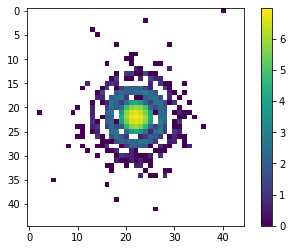

(0, 1119)

In [10]:
plt.imshow(np.fft.fftshift(np.log(data[0, 11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

Now we need to try and reconstruct psi.

In [11]:
# Start with a guess of all zeros for psi
result = {
    'psi': np.zeros(original.shape, dtype=complex) + 1e-32,
    'probe': probe,
}

INFO:tike.ptycho.ptycho:cgrad on 576 - 45 by 45 grids for 8 iterations


# congujate gradient parameters
iteration, step size object, step size probe, function min
   8, 1.250e-01, 0, -1.5839636e+07


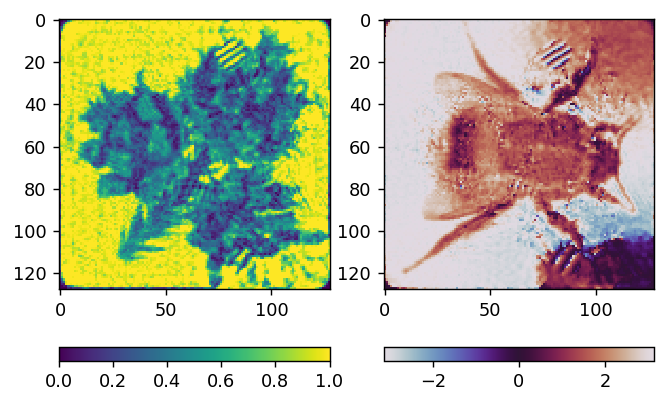

(-1.5466235-0.44574744j) (1.891674+0.16194692j)


In [13]:
for i in range(1):
    result = tike.ptycho.reconstruct(
        data=data,
        scan=scan,
        **result,
        algorithm='cgrad',
        num_iter=8, gamma_psi=1, recover_probe=False,
    )
    tike.view.plot_phase(result['psi'][0], amin=0, amax=1)
#     tike.view.plot_phase(result['probe'][0], amin=0, amax=10)